# msld_py_prep Tutorial for Streamlined MS$\lambda$D Small Molecule Setup

### This tutorial assumes that you are working within a Conda environment and that you have the following tools already loaded:
### - PyMOL
### - ParamChem (CGenFF module)
### - MMTSB 
### - RDKit Python Package
### - Pandas 1.3.4 Python Package
### ... and of course, pyCHARMM

## Problem we are trying to solve: Find a set of common atoms across a molecule set such that the atom type connectivity and atom charges are the same. 

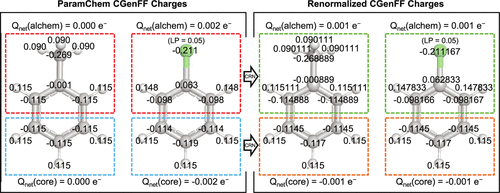

### While the atom type connectivity is relatively easy to find using a Maximum Common Substructure (MCS) search (as we do here), the partial charges of common atoms across similar molecules differ. This is why we perform charge renormalization to get the charges across common atoms to be the same, as shown in the figure above.

### The diagram below shows the typical workflow the msld_py_prep scripts use in order to get files that solve the problem described above.

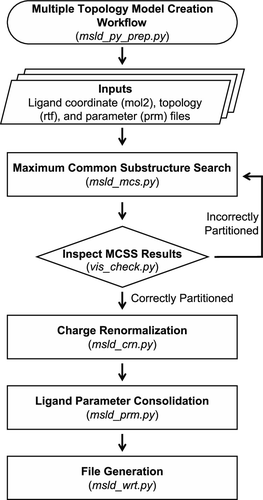

## I. Set Up Dependencies

### We need to make sure we have the msld_py_prep scripts cloned, RDKit installed, PyMOL set up, and that we have a ParamChem module installed and aliased as 'cgenff' ready to use on the terminal

In [18]:
# Clone msld_py_prep GitHub repo
! git clone https://github.com/Vilseck-Lab/msld-py-prep.git

Cloning into 'msld-py-prep'...
remote: Enumerating objects: 810, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 810 (delta 2), reused 1 (delta 1), pack-reused 791
Receiving objects: 100% (810/810), 1.36 MiB | 348.00 KiB/s, done.
Resolving deltas: 100% (338/338), done.


In [1]:
# Install RDKit, pyMOL and pandas to your conda environment if you do not have it already.
# Otherwise use the command below

# Assuming you have a conda environment loaded)
! printf 'y' | conda install -n $CONDA_DEFAULT_ENV -c schrodinger rdkit pymol pandas=1.3.4

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.13.0

Please update conda by running

    $ conda update -n base -c defaults conda


Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.13.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/luiscv/opt/anaconda3/envs/pymol

  added / updated specs:
    - pandas
    - pymol
    - rdkit


The following packages will be UPDATED:

  libgfortran              conda-forge::libgfortran-3.0.1-0 --> schrodinger::libgfortran-3.0.1-2000
  pmw                conda-forge/osx-64::pmw-2.0.1-py38h50~ --> schrodinger/noarch::pmw-2.0.1+3-py_3
  tk                 

In [1]:
# Check that we have a ParamChem module in our setup
# aliased as 'cgenff', as well as pyMOL and MMTSB ready to go,
# specifically the convpdb.pl script

! which cgenff
! which pymol
! which convpdb.pl

/export/apps/CentOS7/cgenff/silcsbio.2022.1/cgenff/cgenff
/export/apps/CentOS7/pymol/pymol2/pymol
/export/apps/CentOS7/mmtsb/src/feig/toolset/perl/convpdb.pl


### This little trick lets us view the structure with pymol provided we started pymol before using `pymol -R &`
### Open a terminal window in jupyter-lab and run `pymol -R &` before running the cell that follows


## II. Curating a Small Molecule Dataset for Input into MSLD

### In a prospective MSLD small-molecule/protein binding study, one usually starts out with a crystal structure of an active lead compound bound to the protein target of interest. The goal is to make small modifications to the ligand scaffold in order to predict changes that will increase affinity or retain it while improving other properties (e.g. solubility). 

### We will start by filtering a substructure from the ChEMBL database of the scaffold for the lead compound shown below, which binds to c-Jun N-terminal Kinase 1 (JNK1),  an important protein target for cancer and neurodegenerative disease treatment. 

<div>
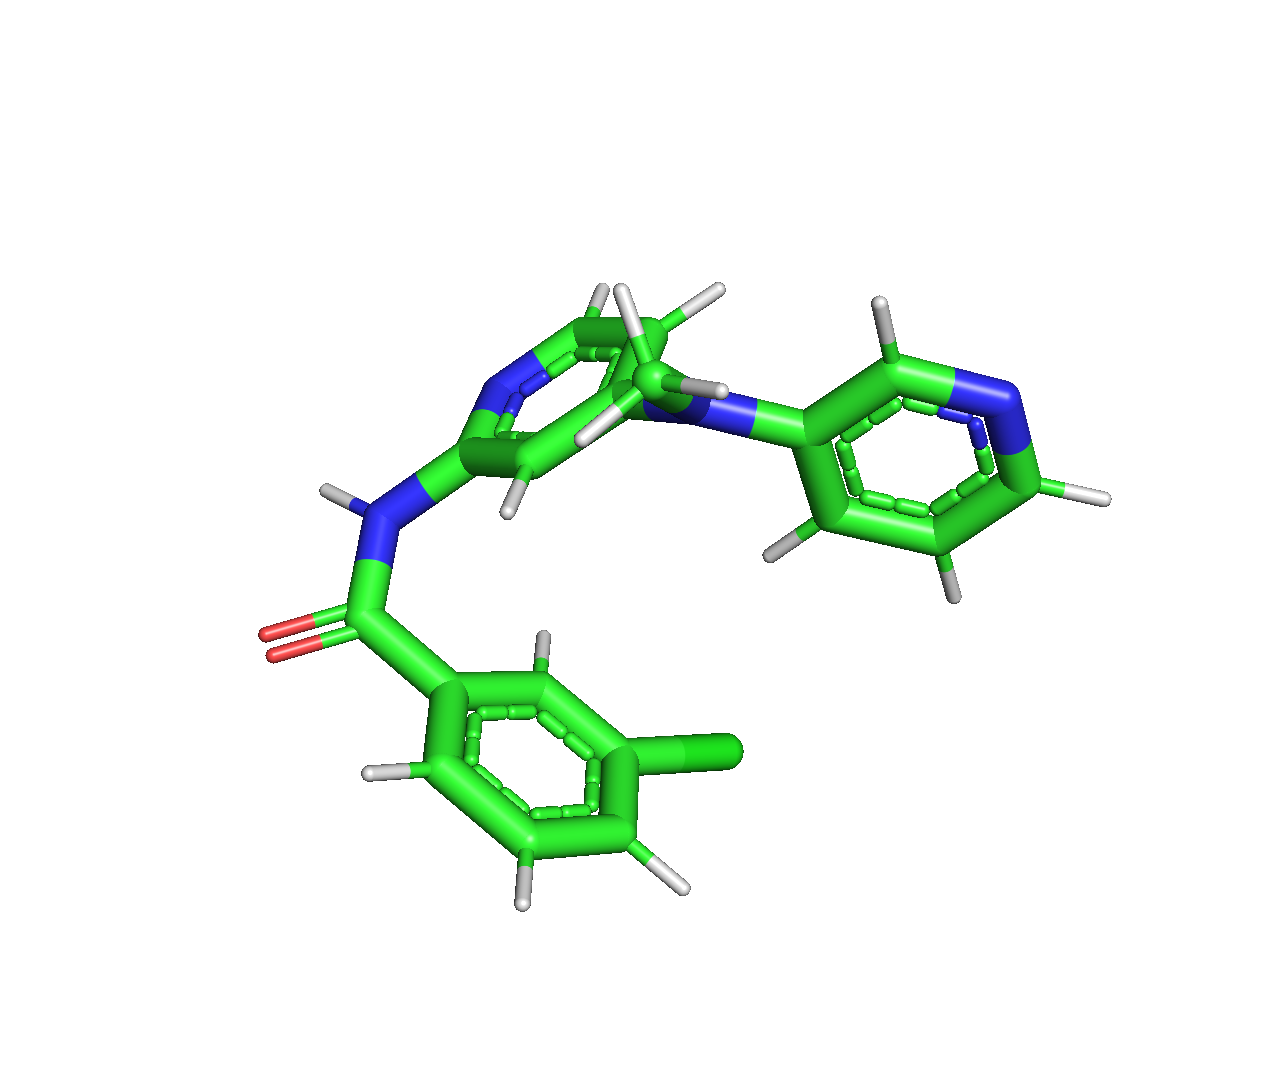
</div>

Matching molecules to pattern...
Done.



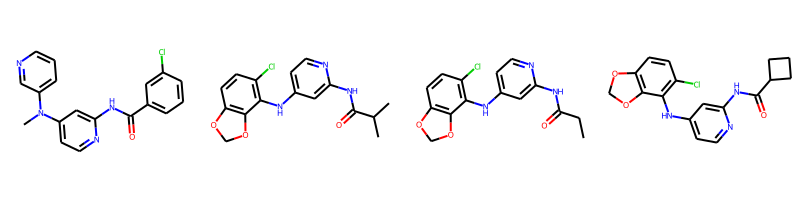

In [7]:
from generate_3D import RDKit_Tools
from IPython.display import Image


dataset = "CHEMBL_Dataset.csv"
dfout= "filtered_df.csv"
# pattern1 = "C12=C(C(CCCOC)=C(C(=O)O[H])N2)C=CC=C1"
# pattern1 = "N1(C(C(=O)NCc2cccc(c2))CCC1)C"
pattern1 = "c1nc(cc(N)c1)NC(=O)C"
names_col = "ChEMBL ID"
smiles_col = "Smiles"
delim=";"
delimout=","
    

mols = RDKit_Tools(dataset, smiles_col=smiles_col, names_col=names_col,delim=delim) # Load molecules into RDKit
matches,indices = mols.filter_molecules(pattern1) # Filter based on smiles pattern
mols.draw_smiles("filtered_mols.png",matches[:50]) # Visualize filtered molecules
mols.get_dataframe(save=dfout,filter_idx=indices, delim=delimout) # Save as csv

Image(filename='filtered_mols.png') # Display molecules

In [3]:
! cp lead.mol2 filtered_df.csv jnk1_ligands/*str msld-py-prep
! cd msld-py-prep

### Now that we have found some new molecules from the ChEMBL database based on the lead scaffold, we now have to generate their 3D structures and align them to the lead compound. We can do that via our PyMOL plugin. We will initialize PyMOL by opening the lead compound typing this in a terminal window: `pymol -R lead.mol2 &`

### To install the PyMOL plugin click: `Plugin tab -> Plugin Manager -> Install New Plugin Tab -> Install from local file "Choose File" button`, then navigate to and select the CRN_Plugin/__init__.py script. Once installed you can find the plugin in the dropdown menu of the Plugin tab.

### Input these specs into the plugin and click the `Align` button to generate mol2 files that are aligned to the lead compound. Specify the msld-py-prep directory when asked where you want to save the output of the alignment.
<div>
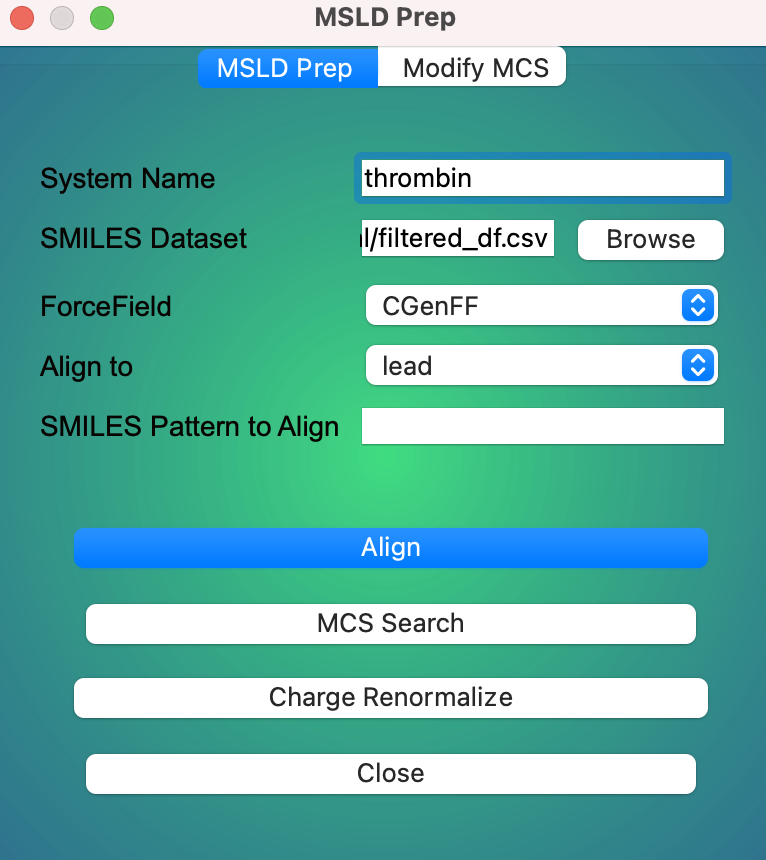
</div>


##  
## III. Setting up a Hybrid Topology System Using Charge Renormalization

### Now that we have aligned molecules with a CHARMM compatible parameter/topology file and a mol2, we can proceed in the plugin by clicking each button sequentially. We can also run msld_py_prep from the command line as follows:

In [ ]:
# Specify molecules you wish to do crn on
! rm mol_list.txt
! echo CHEMBL3818832 >> mol_list.txt
! echo CHEMBL3818920 >> mol_list.txt
! echo CHEMBL3819276 >> mol_list.txt

# Specify system name in msld_py_prep.py
! sed -i 's/\"name\"/\"thrombin\"/g'

# Run MCS Step
! python msld_py_prep.py
! cat MCS_for_MSLD

In [4]:
# Visualize 
from rdkit.Chem import PyMol
v = PyMol.MolViewer()
v.server.do('run_vis_check.py')

/Users/luiscv/umich/research/msld_py_prep_Tutorial


### After running this either through the `run_vis_check.py` command or through the plugin after pressing the `MCS Search` button, you should get the following:


<div>
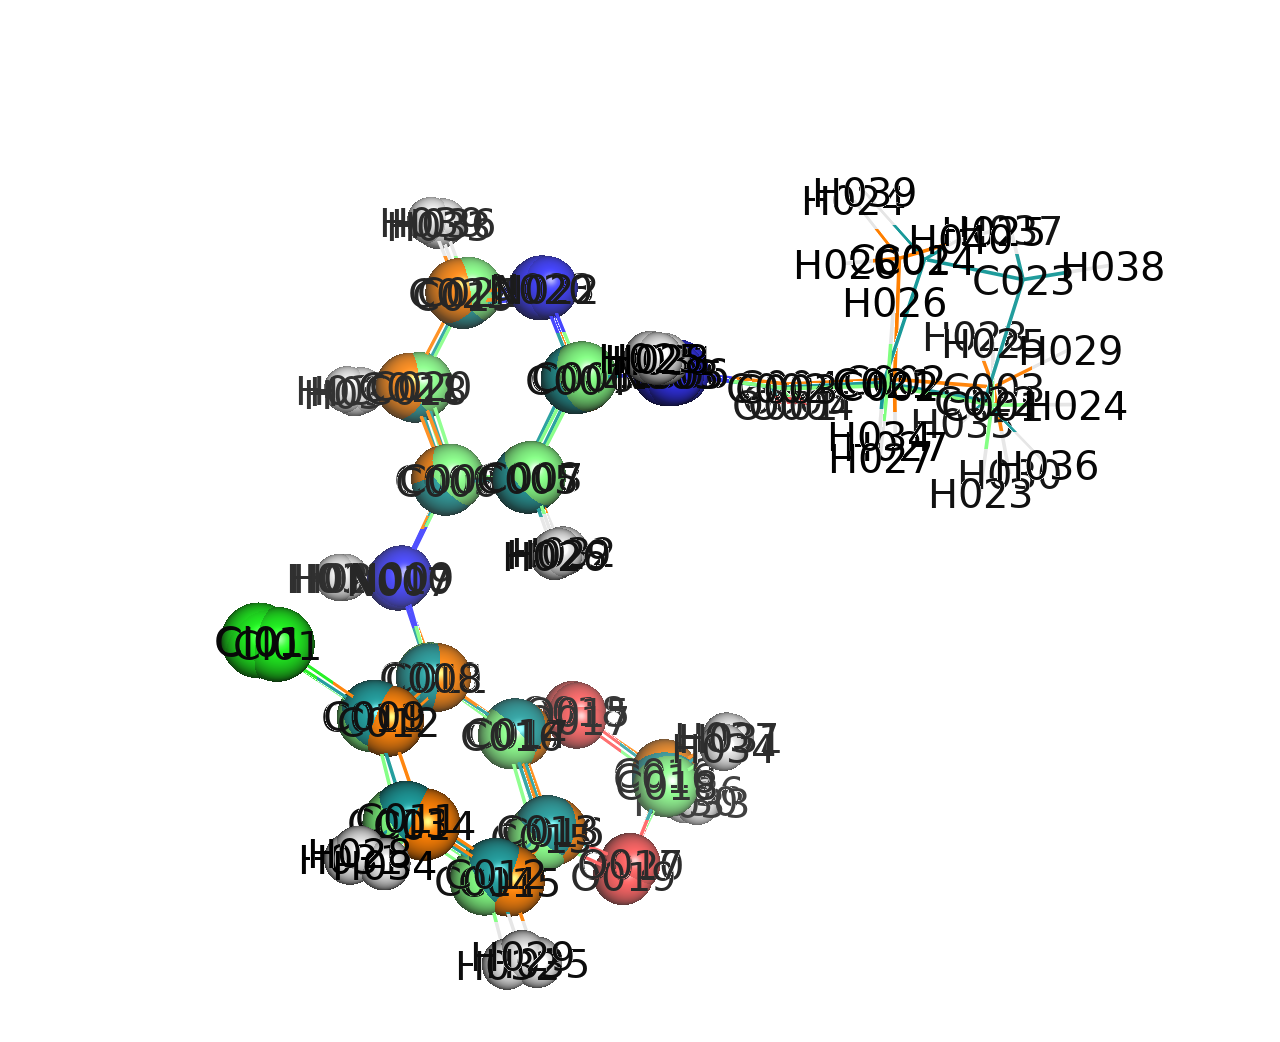
</div>

### Atoms shown as hard spheres are part of the `core` and the ones shown as stick are `substituents`, which we will be transforming alchemically throughout the MSLD simulation. In this case we only have one single site

### We are now ready to do the charge renormalization step, along with the fragmenting of the molecules in order to separate the core from the different fragments/substituents. This should output a directory called `build.jnk1`

In [ ]:
# Run charge renormalization Step 
# (Same command as for MCS Step but scripts identify that we have an `MCS_for_MSLD.txt` file)
! python msld_py_prep.py

### We need to pay close attention to the output to see if we have not changed the charges significantly

### Now that we have made sure that we have not altered the charges as much, we can visualize the pdb files in the `build.jnk1` directory to make sure that we have a correct fragmentation.


<div>
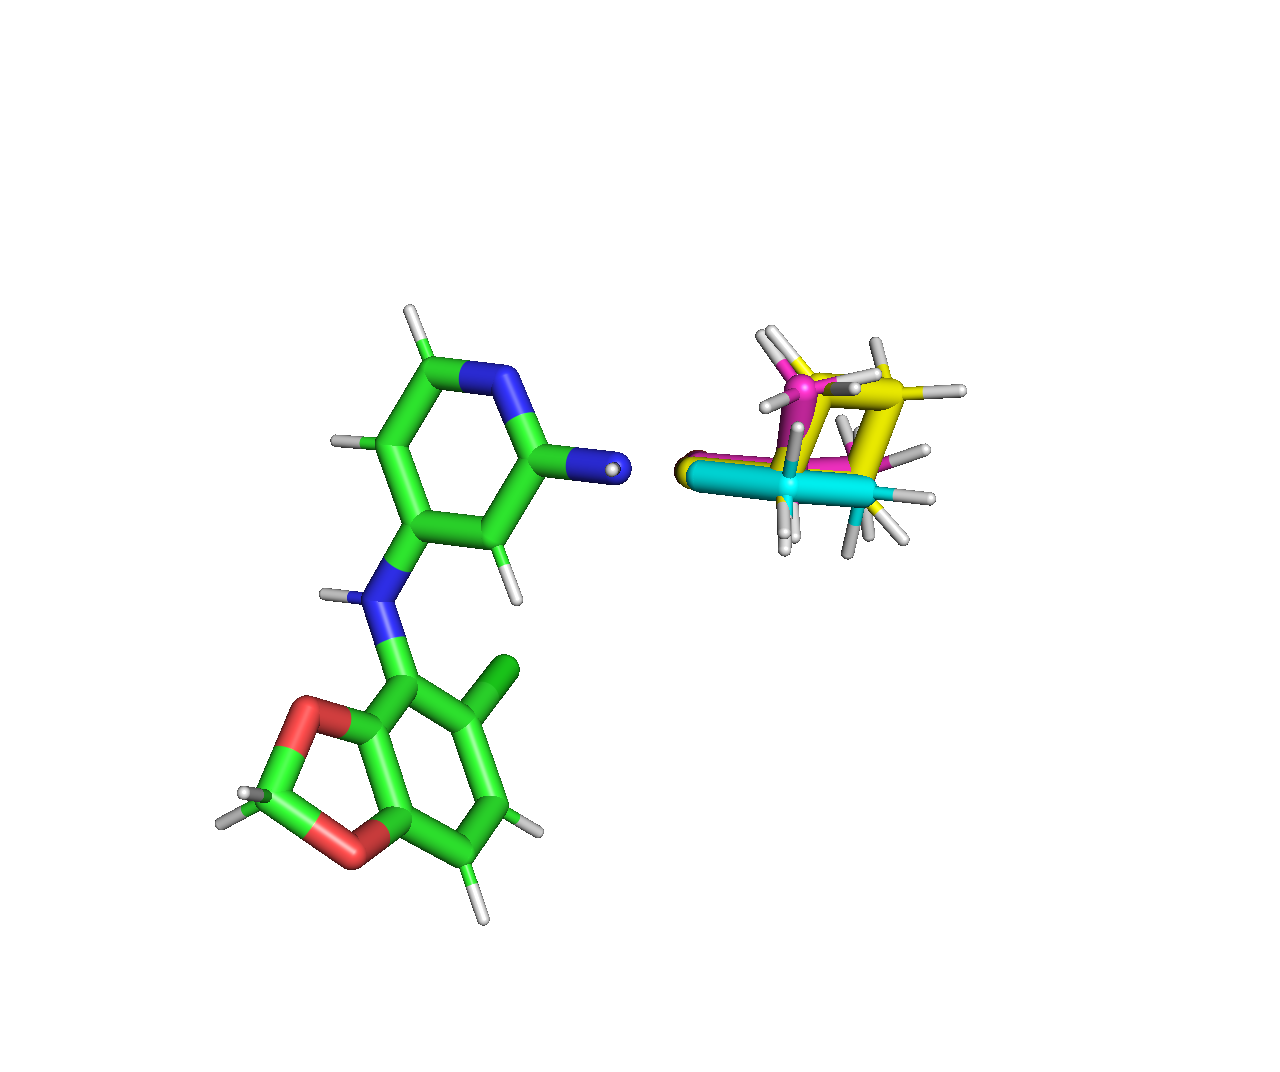
</div>

### We are done! 

### With the correct pdb, rtf, and prm files, as well as a CHARMM MSLD script (`jnk1.inp`) in the `build.jnk1` directory, we are ready for input into MSLD and pyCHARMM.

## pyCHARMM Import

In [ ]:
import os
import sys
import numpy as np

# These are a subset of the pycharmm modules that were installed when
# pycharmm was installed in your python environment
import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm